# Time series prediction of apple stock - Closing price

## Package Install - if necessary

In [37]:
#!conda install --yes -c anaconda pandas-datareader

## Source for the Methodology

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

## Import necessary libraries

In [38]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM # LSTM - Long Short Term Memory
import matplotlib.pyplot as plt
%matplotlib inline

## Get Stock Data from web

In [39]:
#df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-12-20')
df = web.DataReader('POAHF', data_source='yahoo', start='2012-01-01', end='2020-12-20')

In [40]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,54.310001,54.310001,54.310001,54.310001,100.0,40.964706
2012-01-04,53.750000,53.610001,53.610001,53.750000,100.0,40.542309
2012-01-05,53.830002,53.830002,53.830002,53.830002,600.0,40.602657
2012-01-06,52.950001,52.950001,52.950001,52.950001,200.0,39.938889
2012-01-09,53.180000,52.500000,53.180000,52.500000,200.0,39.599468


In [41]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-14,66.419998,65.250000,66.120003,65.360001,300.0,65.360001
2020-12-15,69.349998,68.269997,68.269997,68.699997,700.0,68.699997
2020-12-16,71.230003,70.000000,70.959999,70.750000,9300.0,70.750000
2020-12-17,72.250000,70.250000,70.900002,72.250000,2100.0,72.250000
2020-12-18,70.870003,69.699997,69.699997,70.599998,400.0,70.599998


In [42]:
# Get data description
print('Shape: ',df.shape)
df.describe()

Shape:  (2257, 6)


,High,Low,Open,Close,Volume,Adj Close
count,2257.000000,2257.000000,2257.000000,2257.000000,2257.000000,2257.000000
mean,70.226216,69.585326,69.915791,69.914174,2481.834293,59.363747
std,16.827856,16.808333,16.788851,16.812109,8877.593398,12.898552
min,33.660000,30.240000,31.959999,32.820000,0.000000,31.592096
25%,57.070000,56.509998,56.799999,56.959999,100.000000,48.085064
50%,65.820000,65.110001,65.349998,65.349998,600.000000,59.863270
75%,83.000000,82.410004,82.750000,82.699997,1600.000000,68.742516
max,112.900002,112.169998,112.650002,112.599998,160100.000000,87.164703


## Visualize data of interest

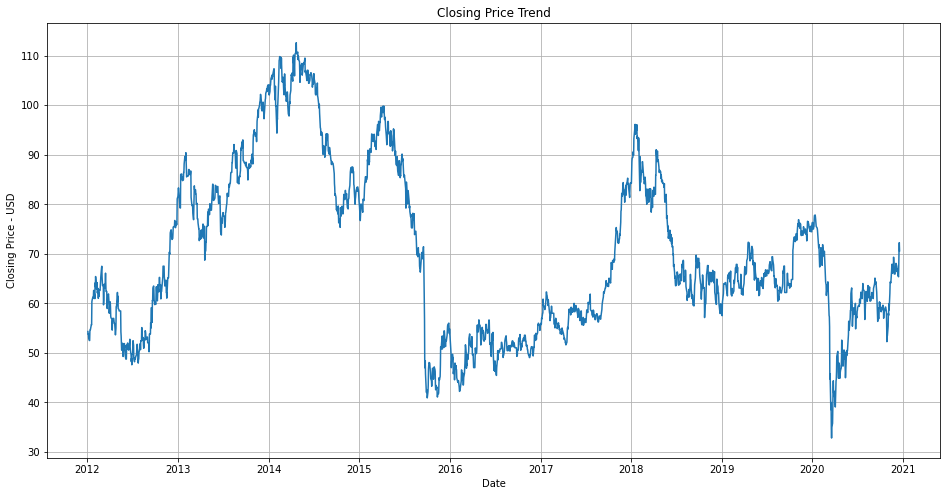

In [43]:
plt.figure(figsize=(16,8))
plt.title('Closing Price Trend')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=10)
plt.ylabel('Closing Price - USD', fontsize = 10)
plt.grid('On')
plt.show()

## Create a new data frame with only 'Close' column - closing price.

In [44]:
data = df.filter(['Close'])
# Convert the data to a numpy array ----> This help us in training
dataset = data.values
# Allot some portion of data to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [45]:
training_data_len

1806

## Scale the data
This is necessary to train the data. It scales values such that they are between 0 and 1.

In [46]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [47]:
scaled_data
scaled_data.shape

(2257, 1)

## Create the training data set from scaled data

In [48]:
train_data = scaled_data[0:training_data_len,:]
# split data to x_train and y_train
x_train = [] # Independent traing variable
y_train = [] # Dependent training variable

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [49]:
# Convert x_train & y_train to numpy arrays
x_train,y_train=np.array(x_train),np.array(y_train)

In [50]:
# Reshape the data - Because LSTM Expects 3D
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1746, 60, 1)

## Create Testing data set to eavluate our modal

In [51]:
# New scaled values to that was not used in training
# That is from index 1807 to 2256 in the original data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [52]:
# Convert data to numpy
x_test = np.array(x_test)
x_test.shape

(451, 60)

In [53]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

# Create Model for training

## Model 1 - LSTM Vanilla

In [54]:
model1 = Sequential()
model1.add(LSTM(50, activation='relu', input_shape=(x_train.shape[1],1)))
model1.add(Dense(1))

## Model 2 - LSTM Stacked

In [55]:
# Build the LSTM model
model2 = Sequential()
model2.add(LSTM(50,activation='relu',return_sequences=True,input_shape=(x_train.shape[1],1)))
model2.add(LSTM(50))
model2.add(Dense(25))
model2.add(Dense(1))

### Compile the models

In [56]:
model1.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [57]:
model2.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

### Fit the models

In [58]:
model1.fit(x_train,y_train,batch_size=1,epochs=1)

1746/1746 [==============================] - 54s 31ms/step - loss: 0.0070 - accuracy: 5.7274e-04


In [59]:
model2.fit(x_train,y_train,batch_size=1,epochs=1)

1746/1746 [==============================] - 101s 58ms/step - loss: 0.0025 - accuracy: 5.7274e-04


## Let there be predictions

In [60]:
predictions1 = model1.predict(x_test)
predictions1 = scaler.inverse_transform(predictions1) # Make the scaled data back to dollar value

In [61]:
predictions2 = model2.predict(x_test)
predictions2 = scaler.inverse_transform(predictions2) # Make the scaled data back to dollar value

### Root mean squared error for both models

In [62]:
rmse_model1=np.sqrt(np.mean(((predictions1- y_test)**2)))
rmse_model1

3.7307126733291764

In [63]:
rmse_model2=np.sqrt(np.mean(((predictions2- y_test)**2)))
rmse_model2

2.611483166354268

### Plot the data

In [64]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions_1'] = predictions1
valid['Predictions_2'] = predictions2

<ipython-input-64-2fae9df26f7c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions_1'] = predictions1
<ipython-input-64-2fae9df26f7c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions_2'] = predictions2


## Visualize the data

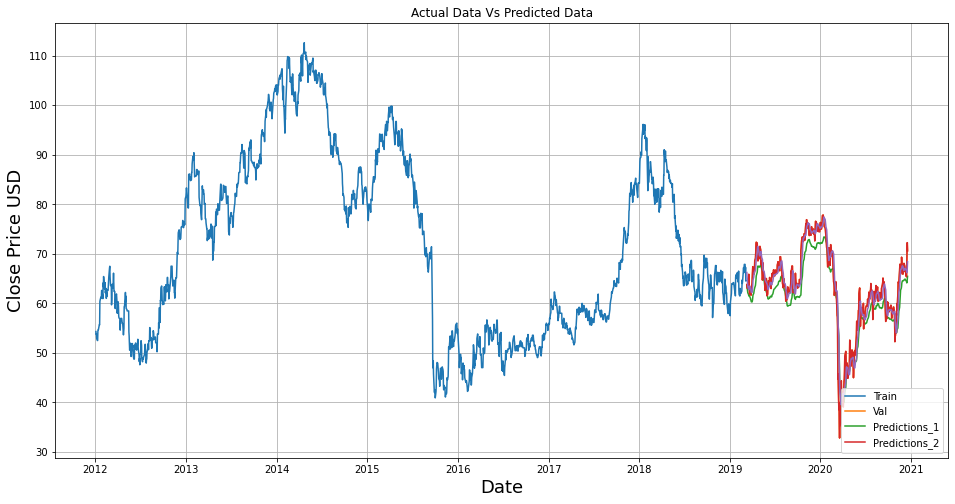

In [65]:
plt.figure(figsize=(16,8))
plt.title('Actual Data Vs Predicted Data')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions_1']])
plt.plot(valid[['Close', 'Predictions_2']])
plt.legend(['Train', 'Val', 'Predictions_1', 'Predictions_2'], loc='lower right')
plt.grid('On')
plt.show()

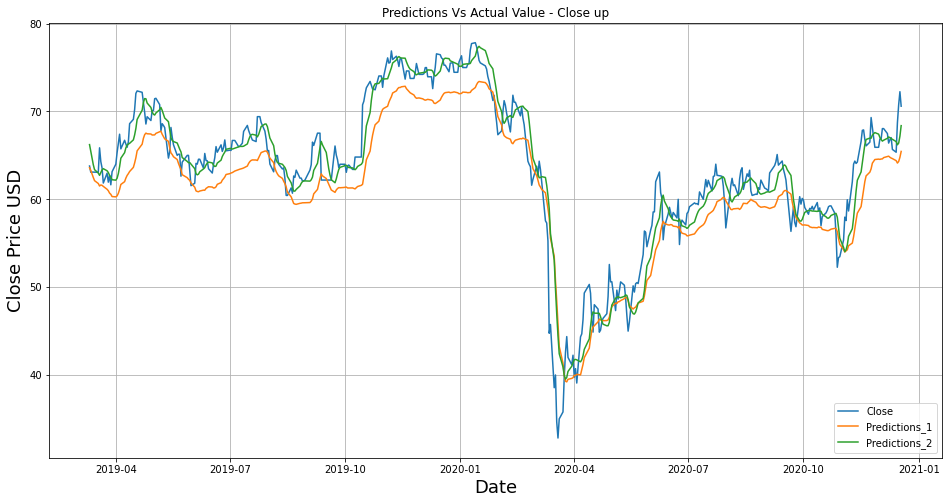

In [66]:
plt.figure(figsize=(16,8))
plt.title('Predictions Vs Actual Value - Close up')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(valid[['Close']])
plt.plot(valid[['Predictions_1']])
plt.plot(valid[['Predictions_2']])
plt.legend(['Close','Predictions_1', 'Predictions_2'], loc='lower right')
plt.grid('On')
plt.show()

In [67]:
valid['Close']

Date
2019-03-11    63.790001
2019-03-12    63.080002
2019-03-13    63.099998
2019-03-14    63.099998
2019-03-15    63.090000
                ...    
2020-12-14    65.360001
2020-12-15    68.699997
2020-12-16    70.750000
2020-12-17    72.250000
2020-12-18    70.599998
Name: Close, Length: 451, dtype: float64